# Diamond Beach project

Honour Booth, Madeline Davis, Christy Chock
12/16/2022 OCN 682

Examining the concentrations of organic ultraviolet filters oxybenzone (BP3) and octocrylene (OC) at 'Diamond Beach' Oahu, Hawaiʻi.

This dataset was collected as clean and tidy. The flow is as follows:
1. undtidying and uncleaning the data
2. recleaning and retidying the data
3. initial data analysis
4. linear mixed models
5. visualization of the models

In conclusion, we found that the density of people per area had the most effect on concentrations of BP3 and OC.


In [225]:
# Loading packages used here
my_packages <- c("tidyverse", "lme4", "nlme", "readxl", "lmerTest", "dplyr", "ggplot2", "gridExtra", "cowplot")

In [226]:
lapply(my_packages, require, character.only = TRUE)

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

# Cleaning and tidying

This includes untidying and retidying of our data set

In [227]:
# List excel sheets
combined_data <- excel_sheets("2_People_untidy_MD.xlsx") %>% map_df(~read_xlsx("2_People_untidy_MD.xlsx",.))
head(combined_data)

Moon,People_total,msq,Date,Time
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Muku,NA,8059.53,20220628,0
Muku,NA,8059.53,20220628,0
Muku,NA,8059.53,20220628,0
Muku,NA,8059.53,20220628,4
Muku,NA,8059.53,20220628,4
Muku,NA,8059.53,20220628,4


In [228]:
# Replace missing values with 0
combined_data[is.na(combined_data)] <- 0

In [229]:
# Divide People_total / msq to get total ppl_msq
combined_data$ppl_msq <- (combined_data$People_total / combined_data$msq)

In [230]:
# All BP3 and OC concentration ([UVF]) data from individual CSV files; str preview showing NA values
conc_muku <- data.frame(read.csv("conc_muku.csv"))
conc_ole <- data.frame(read.csv("conc_ole.csv"))
conc_hoku <- data.frame(read.csv("conc_hoku.csv"))
str(conc_muku)
str(conc_ole)
str(conc_hoku)

'data.frame':	30 obs. of  4 variables:
 $ Moon: chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time: int  0 0 0 4 4 4 8 8 8 9 ...
 $ BP3 : num  12.3 13.9 11.1 20 20.1 ...
 $ OC  : num  NA NA NA NA NA ...
'data.frame':	30 obs. of  4 variables:
 $ Moon: chr  "ʻOlekūkolu" "ʻOlekūkolu" "ʻOlekūkolu" "ʻOlekūkolu" ...
 $ Time: int  0 0 0 4 4 4 8 8 8 9 ...
 $ BP3 : num  21.2 21.5 19.3 20.3 21.7 ...
 $ OC  : num  NA NA NA 15.6 12.8 ...
'data.frame':	30 obs. of  4 variables:
 $ Moon: chr  "Hoku" "Hoku" "Hoku" "Hoku" ...
 $ Time: int  0 0 0 4 4 4 8 8 8 9 ...
 $ BP3 : num  36.9 35.1 35.9 36.6 37.1 ...
 $ OC  : num  87.4 73.7 71 84.2 109.1 ...


In [231]:
# Combine all [UVF] data to one data frame
conc <- rbind(conc_muku, conc_ole, conc_hoku)

In [232]:
# Replace NA values with 0; str preview
conc[is.na(conc)] <- 0
str(conc)

'data.frame':	90 obs. of  4 variables:
 $ Moon: chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time: int  0 0 0 4 4 4 8 8 8 9 ...
 $ BP3 : num  12.3 13.9 11.1 20 20.1 ...
 $ OC  : num  0 0 0 0 0 ...


In [233]:
# Combine [UVF] and pple from combined_data; head preview
conc_pple <- cbind(conc,combined_data)
head(conc_pple)

,Moon,Time,BP3,OC,Moon,People_total,msq,Date,Time,ppl_msq
,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Muku,0,12.34324,0,Muku,0,8059.53,20220628,0,0
2,Muku,0,13.92103,0,Muku,0,8059.53,20220628,0,0
3,Muku,0,11.11400,0,Muku,0,8059.53,20220628,0,0
4,Muku,4,20.03424,0,Muku,0,8059.53,20220628,4,0
5,Muku,4,20.05967,0,Muku,0,8059.53,20220628,4,0
6,Muku,4,18.89155,0,Muku,0,8059.53,20220628,4,0


In [234]:
# Remove duplicate columns, reorganize columns; head preview
conc_pple_2 <- conc_pple[,-5]
conc_pple_3 <- conc_pple_2[,-8]
conc_pple_4 <- conc_pple_3[,-6]
conc_pple_fin <- conc_pple_4 %>% relocate(Date, .after = Moon)
head(conc_pple_fin)

,Moon,Date,Time,BP3,OC,People_total,ppl_msq
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,Muku,20220628,0,12.34324,0,0,0
2,Muku,20220628,0,13.92103,0,0,0
3,Muku,20220628,0,11.11400,0,0,0
4,Muku,20220628,4,20.03424,0,0,0
5,Muku,20220628,4,20.05967,0,0,0
6,Muku,20220628,4,18.89155,0,0,0


In [235]:
# Kaimana_tide dataset
Diamond_data <- read.csv("Diamond_tide.csv")
str(Diamond_data)

'data.frame':	90 obs. of  6 variables:
 $ Date    : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon    : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time    : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide    : num  0.271 0.271 0.271 0.505 0.505 ...
 $ PreTide : num  0.24 0.24 0.24 0.54 0.54 0.54 0.54 0.54 0.54 -0.15 ...
 $ PostTide: num  0.54 0.54 0.54 -0.15 -0.15 -0.15 -0.15 -0.15 -0.15 2.28 ...


In [236]:
# Combining PreTide and PostTide columns into one
Diamond_data$PreTide_PostTide <- paste(Diamond_data$PreTide, Diamond_data$PostTide, sep="_")
str(Diamond_data)

'data.frame':	90 obs. of  7 variables:
 $ Date            : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon            : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time            : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide            : num  0.271 0.271 0.271 0.505 0.505 ...
 $ PreTide         : num  0.24 0.24 0.24 0.54 0.54 0.54 0.54 0.54 0.54 -0.15 ...
 $ PostTide        : num  0.54 0.54 0.54 -0.15 -0.15 -0.15 -0.15 -0.15 -0.15 2.28 ...
 $ PreTide_PostTide: chr  "0.24_0.54" "0.24_0.54" "0.24_0.54" "0.54_-0.15" ...


In [237]:
# Removing old columns
# Download this one as csv
tide <- Diamond_data[c("Date", "Moon", "Time", "Tide", "PreTide_PostTide")]
str(tide)

'data.frame':	90 obs. of  5 variables:
 $ Date            : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon            : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time            : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide            : num  0.271 0.271 0.271 0.505 0.505 ...
 $ PreTide_PostTide: chr  "0.24_0.54" "0.24_0.54" "0.24_0.54" "0.54_-0.15" ...


In [238]:
# Tidying up the data again (Cleaning)
tide[c('PreTide', 'PostTide')] <- str_split_fixed(tide$PreTide_PostTide, '_', 2)
str(tide)

'data.frame':	90 obs. of  7 variables:
 $ Date            : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon            : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time            : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide            : num  0.271 0.271 0.271 0.505 0.505 ...
 $ PreTide_PostTide: chr  "0.24_0.54" "0.24_0.54" "0.24_0.54" "0.54_-0.15" ...
 $ PreTide         : chr  "0.24" "0.24" "0.24" "0.54" ...
 $ PostTide        : chr  "0.54" "0.54" "0.54" "-0.15" ...


In [239]:
# Removing extra joint column (Cleaning)
tide_2 <- tide[c("Date", "Moon", "Time", "Tide", "PreTide", "PostTide")]
str(tide_2)

'data.frame':	90 obs. of  6 variables:
 $ Date    : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon    : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time    : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide    : num  0.271 0.271 0.271 0.505 0.505 ...
 $ PreTide : chr  "0.24" "0.24" "0.24" "0.54" ...
 $ PostTide: chr  "0.54" "0.54" "0.54" "-0.15" ...


In [240]:
# Convert Tide column from inches to meters
tide_2$Tide <- tide_2$Tide * 0.3048
str(tide_2)

'data.frame':	90 obs. of  6 variables:
 $ Date    : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon    : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time    : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide    : num  0.0826 0.0826 0.0826 0.1541 0.1541 ...
 $ PreTide : chr  "0.24" "0.24" "0.24" "0.54" ...
 $ PostTide: chr  "0.54" "0.54" "0.54" "-0.15" ...


In [241]:
# Changing PreTide and PostTide columns from character to double strings
tide_2$PreTide = as.double(tide_2$PreTide)
tide_2$PostTide = as.double(tide_2$PostTide)
str(tide_2)

'data.frame':	90 obs. of  6 variables:
 $ Date    : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon    : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time    : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide    : num  0.0826 0.0826 0.0826 0.1541 0.1541 ...
 $ PreTide : num  0.24 0.24 0.24 0.54 0.54 0.54 0.54 0.54 0.54 -0.15 ...
 $ PostTide: num  0.54 0.54 0.54 -0.15 -0.15 -0.15 -0.15 -0.15 -0.15 2.28 ...


In [242]:
# Convert PreTide and PostTide columns from inches to meters
tide_2$PreTide <- tide_2$PreTide * 0.3048
tide_2$PostTide <- tide_2$PostTide * 0.3048
str(tide_2)

'data.frame':	90 obs. of  6 variables:
 $ Date    : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon    : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time    : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide    : num  0.0826 0.0826 0.0826 0.1541 0.1541 ...
 $ PreTide : num  0.0732 0.0732 0.0732 0.1646 0.1646 ...
 $ PostTide: num  0.1646 0.1646 0.1646 -0.0457 -0.0457 ...


In [243]:
# Combine [UVF] and pple data with tidal data from tide_2
Diamond_all <- cbind(conc_pple_fin,tide_2)
head(Diamond_all)

,Moon,Date,Time,BP3,OC,People_total,ppl_msq,Date,Moon,Time,Tide,PreTide,PostTide
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Muku,20220628,0,12.34324,0,0,0,20220628,Muku,0,0.08264164,0.073152,0.164592
2,Muku,20220628,0,13.92103,0,0,0,20220628,Muku,0,0.08264164,0.073152,0.164592
3,Muku,20220628,0,11.11400,0,0,0,20220628,Muku,0,0.08264164,0.073152,0.164592
4,Muku,20220628,4,20.03424,0,0,0,20220628,Muku,4,0.15407579,0.164592,-0.045720
5,Muku,20220628,4,20.05967,0,0,0,20220628,Muku,4,0.15407579,0.164592,-0.045720
6,Muku,20220628,4,18.89155,0,0,0,20220628,Muku,4,0.15407579,0.164592,-0.045720


In [244]:
# Remove duplicate columns
Diamond_all_1 <- Diamond_all[,-10]
Diamond_all_2 <- Diamond_all_1[,-9]
Diamond_all_fin <- Diamond_all_2[,-8]

In [245]:
str(Diamond_all_fin)

'data.frame':	90 obs. of  10 variables:
 $ Moon        : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Date        : num  20220628 20220628 20220628 20220628 20220628 ...
 $ Time        : int  0 0 0 4 4 4 8 8 8 9 ...
 $ BP3         : num  12.3 13.9 11.1 20 20.1 ...
 $ OC          : num  0 0 0 0 0 ...
 $ People_total: num  0 0 0 0 0 0 9 9 9 11 ...
 $ ppl_msq     : num  0 0 0 0 0 ...
 $ Tide        : num  0.0826 0.0826 0.0826 0.1541 0.1541 ...
 $ PreTide     : num  0.0732 0.0732 0.0732 0.1646 0.1646 ...
 $ PostTide    : num  0.1646 0.1646 0.1646 -0.0457 -0.0457 ...


In [246]:
# Export finished tidy csv file
write.csv(Diamond_all_fin, "DiamondBeach_all.csv")

The cvs "DiamondBeach_all" was manually edited to include NA in BP3 and OC columns for the following times: 9,10,11,13,14,15,17,18,19. This csv file was renamed "DiamondBeach_all_fin" and used in code. NA is more appropriate that 0 as samples were not collected at these times, and 0 is not an accurate representation of UVF concentrations at these times. Data for other variables (people per area) at these times is required for visualization in exploratory data analysis.

# Exploratory data analysis

Here is our initial assessment of variations between the values.

In [247]:
### loading libraries
library(ggpubr)
library(tidyverse)
library(ggplot2)
library(gridExtra)

In [248]:
### DiamondBeach_all Dataset
DiamondBeach_data <- read.csv("DiamondBeach_all_fin.csv")

In [249]:
### Making Muku (New Moon)phase dataframe
Muku <-head(DiamondBeach_data, n=30)

In [250]:
### Making Muku (New Moon) and Number of People dataframe
Muku_people<-Muku[, c("Time","People_total")]

In [251]:
### Plotting Muku (New Moon) vs. Number of People
Muku.ppl <- ggplot(Muku_people, aes(Time, People_total)) + 
geom_bar(position = "dodge",
           stat = "summary",
           fun = "mean", fill = "blue")+
    labs(x ="Muku (New Moon)", y = "Number of People")

In [252]:
### Making 'Olekukolu (Half Moon) phase dataframe
Olekukolu <-DiamondBeach_data[31:60,] 

In [253]:
### Making 'Olekukolu (Half Moon) and Number of People dataframe
Olekukolu_people<-Olekukolu[, c("Time","People_total")]

In [254]:
### Plotting Olekukolu (Half Moon) vs. Number of People
Olekukolu.ppl <- ggplot(Olekukolu_people, aes(Time, People_total)) + 
geom_bar(position = "dodge",
           stat = "summary",
           fun = "mean", fill = "purple") +
    labs(x ="Olekukolu (Half Moon)", y = "")

In [255]:
### Making Hoku (Full Moon) phase dataframe
Hoku <-DiamondBeach_data[61:90,] 

In [256]:
### Making Hoku (Full Moon) and Number of People dataframe
Hoku_people<-Hoku[, c("Time","People_total")]

In [257]:
### Plotting Hoku (Full Moon) vs. Number of People
Hoku.ppl <- ggplot(Hoku_people, aes(Time, People_total)) + 
geom_bar(position = "dodge",
           stat = "summary",
           fun = "mean", fill = "pink") +
    labs(x ="Hoku (Full Moon)", y = "")      

In [258]:
### Making Muku (New Moon) and Tide Height (m) dataframe
Muku_tide<-Muku[, c("Time","Tide")]

In [259]:
### Plotting Muku (New Moon) vs. Tide Height (m)
Muku.tide <- ggplot(data = Muku_tide) +
    geom_line(aes(x = Time, y = Tide),color = "green", size = 2)+
    labs(x = "", y = "Tide Height (m)")

In [260]:
### Making 'Olekukolu (Half Moon) and Tide Height (m) dataframe
Olekukolu_tide<-Olekukolu[, c("Time","Tide")]

In [261]:
### Plotting 'Olekukolu (Half Moon) vs. Tide Height (m)
Olekukolu.tide <- ggplot(data = Olekukolu_tide) +
    geom_line(aes(x = Time, y = Tide),color = "orange", size = 2)+
    labs(x = "", y = "")

In [262]:
### Making Hoku (Full Moon) and Tide Height (m) dataframe
Hoku_tide<-Hoku[, c("Time","Tide")]

In [263]:
### Plotting Hoku (Full Moon) vs. Tide Height (m)
Hoku.tide <- ggplot(data = Hoku_tide) +
    geom_line(aes(x = Time, y = Tide),color = "yellow", size = 2)+
    labs(x = "", y = "") 

In [264]:
### Making Muku (New Moon) and BP3 dataframe
Muku_BP3<-Muku[, c("Time","BP3")]
Muku_BP3<-na.omit(Muku_BP3)

In [265]:
### Plotting Muku (New Moon) vs. BP3 replicates (mg/L)
Muku.vs.BP3.replicates <- ggplot(data = Muku_BP3) +
    geom_point(aes(x = Time, y = BP3),color = "red", size = 4)+
    labs(x = "", y = "BP3 (mg/L)")

In [266]:
### Making 'Olekukolu (Half Moon) and Tide Height (m) dataframe
Olekukolu_BP3<-Olekukolu[, c("Time","BP3")]
Olekukolu_BP3<-na.omit(Olekukolu_BP3)

In [267]:
### Plotting 'Olekukolu (Half Moon) vs. BP3 replicates (mg/L)
Olekukolu.vs.BP3.replicates <- ggplot(data = Olekukolu_BP3) +
    geom_point(aes(x = Time, y = BP3),color = "cyan", size = 4)+
    labs(x = "",y = "") 

In [268]:
### Making Hoku (Full Moon) and BP3 dataframe
Hoku_BP3<-Hoku[, c("Time","BP3")]
Hoku_BP3<-na.omit(Hoku_BP3)

In [269]:
### Plotting Hoku (Full Moon) vs. BP3 replicates (mg/L)
### Plotting Hoku (Full Moon) vs. BP3 replicates (mg/L)
Hoku.vs.BP3.replicates <- ggplot(data = Hoku_BP3) +
    geom_point(aes(x = Time, y = BP3),color = "brown", size = 4)+
    labs(x = "",y = "") 

In [270]:
### Making Muku (New Moon) and OC dataframe
Muku_OC<-Muku[, c("Time","OC")]
Muku_OC<-na.omit(Muku_OC)

In [271]:
### Plotting Muku (New Moon) vs. OC replicates (mg/L)
Muku.vs.OC.replicates <- ggplot(data = Muku_OC) +
    geom_point(aes(x = Time, y = OC),color = "gold", size = 4)+
    labs(x = "",y = "OC (mg/L)")

In [272]:
### Making 'Olekukolu (Half Moon) and OC dataframe
Olekukolu_OC<-Muku[, c("Time","OC")]
Olekukolu_OC<-na.omit(Olekukolu_OC)

In [273]:
### Plotting 'Olekukolu (Half Moon) vs. OC replicates (mg/L)
Olekukolu.vs.OC.replicates <- ggplot(data = Olekukolu_OC) +
    geom_point(aes(x = Time, y = OC),color = "dark green", size = 4)+
    labs(x = "",y = "") 

In [274]:
### Making Hoku (Full Moon) and OC dataframe
Hoku_OC<-Hoku[, c("Time","OC")]
Hoku_OC<-na.omit(Hoku_OC)

In [275]:
### Plotting Hoku (Full Moon) vs. OC replicates (mg/L)
Hoku.vs.OC.replicates <- ggplot(data = Hoku_OC) +
    geom_point(aes(x = Time, y = OC),color = "deepskyblue", size = 4)+
    labs(x = "",y = "") 

In [276]:
### Calculate the BP3 mean for Muku values
BP3_mean <- tapply(Muku_BP3$BP3,Muku_BP3$Time,mean)

In [277]:
#data.frame(BP3_mean for Muku (New Moon))
Time_data <- c(0,4,8,12,16,20,24)
Time <- as.integer(Time_data)
combined_BP3_mean <- cbind(Time,BP3_mean)
head(data.frame(combined_BP3_mean))

,Time,BP3_mean
,<dbl>,<dbl>
0,0,12.45942
4,4,19.66182
8,8,13.49042
12,12,17.60934
16,16,207.80959
20,20,16.18580


In [278]:
### Plotting Muku (New Moon) vs. BP3 mean (mg/L)
Muku.vs.BP3.mean <- qplot(Time, BP3_mean,  xlab = "Muku (New Moon)",
      ylab = "BP3 mean (mg/L)",
      main = "Muku (New Moon) vs. BP3 mean",
      size = I(4), color = "BP3 mean_Muku")

In [279]:
### Calculate the OC mean for 'Olekukolu (Half Moon) values
Olekukolu_mean <- tapply(Olekukolu_OC$OC,Olekukolu_OC$Time,mean)

In [280]:
#data.frame(BP3_mean for 'Olekukolu (Half Moon))
Time_BP3_mean <- c(0,4,8,12,16,20,24)
Time <- as.integer(Time_BP3_mean)
combined_Olekukolu_mean <- cbind(Time,Olekukolu_mean)
head(data.frame(combined_Olekukolu_mean))

,Time,Olekukolu_mean
,<dbl>,<dbl>
0,0,0.00000
4,4,0.00000
8,8,81.68983
12,12,64.44740
16,16,1243.36996
20,20,89.99121


In [281]:
### Plotting 'Olekukolu (Half Moon) vs. BP3 mean (mg/L)
Olekukolu.vs.BP3.mean <- qplot(Time, Olekukolu_mean,  xlab = "Olekukolu (Half Moon)",
      ylab = "BP3 mean (mg/L)",
      main = "Plot 8.3 (Olekukolu (Half Moon) vs. BP3 mean)",
      size = I(4), color = "BP3 mean_Olekukolu")

In [282]:
### Calculate the BP3 mean for Hoku (Full Moon) values
Hoku_mean <- tapply(Hoku_BP3$BP3,Hoku_BP3$Time,mean)

In [283]:
#data.frame(BP3_mean for Hoku (Full Moon))
#(0,4,8,9,10,11,12,13,14,15,16,17,18,19,20,24)
Time_BP3_mean <- c(0,4,8,12,16,20,24)
Time <- as.integer(Time_BP3_mean)
combined_Hoku_mean <- cbind(Time,Hoku_mean)
head(data.frame(combined_Hoku_mean))

,Time,Hoku_mean
,<dbl>,<dbl>
0,0,35.97264
4,4,36.14388
8,8,43.43318
12,12,36.28882
16,16,240.88296
20,20,39.15150


In [284]:
### Plotting Hoku (Full Moon) vs. BP3 mean (mg/L)
Hoku.vs.BP3.mean <- qplot(Time, Hoku_mean,  xlab = "Hoku (Full Moon)",
      ylab = "BP3 mean (mg/L)",
      main = "Plot 9.3 (Hoku (Full Moon) vs. BP3 mean)",
      size = I(4), color = "BP3 mean_Hoku")

In [285]:
### Calculate the OC mean for Muku (New Moon) values
OC_mean <- tapply(Muku_OC$OC,Muku_OC$Time,mean)

In [286]:
#data.frame(OC_mean) for Muku (New Moon) values
Time_OC_mean <- c(0,4,8,12,16,20,24)
Time <- as.integer(Time_OC_mean)
combined_OC_mean <- cbind(Time,OC_mean)
head(data.frame(combined_OC_mean))

,Time,OC_mean
,<dbl>,<dbl>
0,0,0.00000
4,4,0.00000
8,8,81.68983
12,12,64.44740
16,16,1243.36996
20,20,89.99121


In [287]:
### Plotting Muku (New Moon) vs. OC mean (mg/L)
Muku.vs.OC.mean <- qplot(Time, OC_mean,  xlab = "Muku (New Moon)",
      ylab = "OC mean (mg/L)",
      main = "Plot 7.4 (Muku (New Moon) vs. OC mean)",
      size = I(4), color = "OC mean_Muku")

In [288]:
### Calculate the OC mean for 'Olekukolu (Half Moon) values
OC_mean <- tapply(Olekukolu_OC$OC,Olekukolu_OC$Time,mean)

In [289]:
#data.frame(OC_mean) for 'Olekukolu (Half Moon) values
Time_OC_mean <- c(0,4,8,12,16,20,24)
Time <- as.integer(Time_OC_mean)
combined_OC_mean <- cbind(Time,OC_mean)
head(data.frame(combined_OC_mean))

,Time,OC_mean
,<dbl>,<dbl>
0,0,0.00000
4,4,0.00000
8,8,81.68983
12,12,64.44740
16,16,1243.36996
20,20,89.99121


In [290]:
### Plotting 'Olekukolu (Half Moon) vs. OC mean (mg/L)
Olekukolu.vs.OC.mean <- qplot(Time, OC_mean,  xlab = "'Olekukolu (Half Moon)",
      ylab = "OC mean (mg/L)",
      main = "'Olekukolu (Half Moon) vs. OC mean",
      size = I(4), color = "OC mean_'Olekukolu")

In [291]:
### Calculate the OC mean for Hoku (Full Moon) values
OC_mean <- tapply(Hoku_OC$OC,Hoku_OC$Time,mean)

In [292]:
#data.frame(OC_mean) for Hoku (Full Moon) values
Time_OC_mean <- c(0,4,8,12,16,20,24)
Time <- as.integer(Time_OC_mean)
combined_OC_mean <- cbind(Time,OC_mean)
head(data.frame(combined_OC_mean))

,Time,OC_mean
,<dbl>,<dbl>
0,0,77.35726
4,4,93.13995
8,8,87.05138
12,12,202.21011
16,16,846.08078
20,20,114.38566


In [293]:
### Plotting Hoku (Full Moon) vs. OC mean (mg/L)
Hoku.vs.OC.mean <- qplot(Time, OC_mean,  xlab = "Hoku (Full Moon)",
      ylab = "BP3 mean (mg/L)",
      main = "Hoku (Full Moon) vs. OC mean",
      size = I(4), color = "OC mean_Hoku")

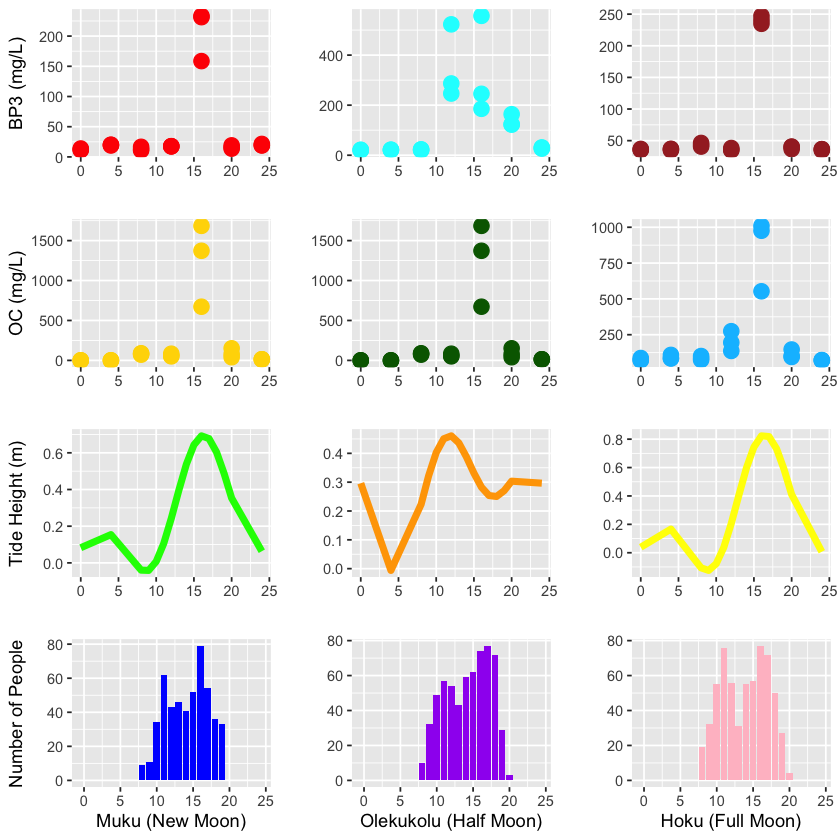

In [294]:
# Arranging Concentration, Tide, and People per area as tiled graphs 
plot_grid(Muku.vs.BP3.replicates, Olekukolu.vs.BP3.replicates, Hoku.vs.BP3.replicates,
          Muku.vs.OC.replicates, Olekukolu.vs.OC.replicates, Hoku.vs.OC.replicates,
    Muku.tide, Olekukolu.tide, Hoku.tide, 
         Muku.ppl, Olekukolu.ppl, Hoku.ppl, align = "hv", nrow = 4)

# Linear mixed model creation

This section uses the 'lme4' and 'lm' packages

In [295]:
# This is the start of mixed model creation

In [296]:
# The values need to be scaled for the appropriate model

In [297]:
Diamond_all_fin <- read.csv("DiamondBeach_all_fin.csv")
Diamond_all_fin<-na.omit(Diamond_all_fin)

In [298]:
Diamond_all_fin$ppl_msq_s <- scale(Diamond_all_fin$ppl_msq) 

In [299]:
Diamond_all_fin$Time_s <- scale(Diamond_all_fin$Time) 

In [300]:
Diamond_all_fin$Tide_s <- scale(Diamond_all_fin$Tide) 

In [301]:
Diamond_all_fin$Time <- as.numeric(Diamond_all_fin$Time)

In [302]:
Diamond_all_fin = Diamond_all_fin %>%
mutate(Moon_s = recode(Diamond_all_fin$Moon, 
                      "Muku" = 1, 
                      "Olekukolu" = 2, 
                      "Hoku" = 3))

In [303]:
Diamond_all_fin

,X,Moon,Date,Time,BP3,OC,People_total,ppl_msq,Tide,PreTide,PostTide,ppl_msq_s,Time_s,Tide_s,Moon_s
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<dbl>
1,1,Muku,20220628,0,12.34324,0.000000,0,0.000000000,0.082641643,0.073152,0.164592,-0.7025836,-1.4880476,-0.67272253,1
2,2,Muku,20220628,0,13.92103,0.000000,0,0.000000000,0.082641643,0.073152,0.164592,-0.7025836,-1.4880476,-0.67272253,1
3,3,Muku,20220628,0,11.11400,0.000000,0,0.000000000,0.082641643,0.073152,0.164592,-0.7025836,-1.4880476,-0.67272253,1
4,4,Muku,20220628,4,20.03424,0.000000,0,0.000000000,0.154075790,0.164592,-0.045720,-0.7025836,-0.9920317,-0.35889923,1
5,5,Muku,20220628,4,20.05967,0.000000,0,0.000000000,0.154075790,0.164592,-0.045720,-0.7025836,-0.9920317,-0.35889923,1
6,6,Muku,20220628,4,18.89155,0.000000,0,0.000000000,0.154075790,0.164592,-0.045720,-0.7025836,-0.9920317,-0.35889923,1
7,7,Muku,20220628,8,10.77351,84.056500,9,0.001116690,-0.039571270,0.164592,-0.045720,-0.3923307,-0.4960159,-1.20962625,1
8,8,Muku,20220628,8,16.71569,89.256500,9,0.001116690,-0.039571270,0.164592,-0.045720,-0.3923307,-0.4960159,-1.20962625,1
9,9,Muku,20220628,8,12.98207,71.756500,9,0.001116690,-0.039571270,0.164592,-0.045720,-0.3923307,-0.4960159,-1.20962625,1


In [304]:
# Time of day effect on people m^2 using 'lm'
# P value shows effect on ppl_msq from time is significant
T_o_D_ppl_msq <- lm(ppl_msq ~ Time, data = Diamond_all_fin)
summary(T_o_D_ppl_msq)


Call:
lm(formula = ppl_msq ~ Time, data = Diamond_all_fin)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.003442 -0.002641 -0.001616  0.002806  0.006969 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept) 1.616e-03  8.121e-04   1.990   0.0511 .
Time        7.607e-05  5.631e-05   1.351   0.1817  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.003576 on 61 degrees of freedom
Multiple R-squared:  0.02905,	Adjusted R-squared:  0.01313 
F-statistic: 1.825 on 1 and 61 DF,  p-value: 0.1817


In [305]:
# Time of day effect on tide using 'lm'
# P value shows effect on ppl_msq from time is significant
T_o_D_Tide <- lm(Tide ~ Time_s, data = Diamond_all_fin)
summary(T_o_D_Tide)


Call:
lm(formula = Tide ~ Time_s, data = Diamond_all_fin)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33847 -0.08713 -0.00551  0.04405  0.55094 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.23577    0.02735   8.620  3.8e-12 ***
Time_s       0.07375    0.02757   2.675  0.00958 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2171 on 61 degrees of freedom
Multiple R-squared:  0.105,	Adjusted R-squared:  0.09031 
F-statistic: 7.155 on 1 and 61 DF,  p-value: 0.009583


In [306]:
# LMM 1
# Concentration of BP3 by time of day and ppl_msq
BP3.vs.time.ppl <- lmer(BP3 ~ Time_s + ppl_msq_s + (1|Moon_s), data = Diamond_all_fin)
summary(BP3.vs.time.ppl)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: BP3 ~ Time_s + ppl_msq_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 704.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6968 -0.4895  0.1180  0.4182  4.1155 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept) 1690     41.10   
 Residual             5575     74.66   
Number of obs: 63, groups:  Moon_s, 3

Fixed effects:
            Estimate Std. Error     df t value Pr(>|t|)    
(Intercept)   80.265     25.528  2.000   3.144    0.088 .  
Time_s         9.928      9.623 58.002   1.032    0.307    
ppl_msq_s     79.156      9.634 58.043   8.216 2.65e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr) Time_s
Time_s     0.000       
ppl_msq_s  0.000 -0.171

In [307]:
# LMM2
# Concentration of OC by time of day and ppl_msq
OC.vs.time.ppl <- lmer(OC ~ Time_s + ppl_msq_s + (1|Moon_s), data = Diamond_all_fin)
summary(OC.vs.time.ppl)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: OC ~ Time_s + ppl_msq_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 915.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4070 -0.4386  0.0301  0.2650  5.9251 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)  41630   204.0   
 Residual             191212   437.3   
Number of obs: 63, groups:  Moon_s, 3

Fixed effects:
            Estimate Std. Error     df t value Pr(>|t|)    
(Intercept)   340.47     130.04   2.00   2.618    0.120    
Time_s         35.42      56.36  58.00   0.628    0.532    
ppl_msq_s     439.50      56.42  58.06   7.790 1.37e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr) Time_s
Time_s     0.000       
ppl_msq_s  0.000 -0.171

In [308]:
# LMM3
# Concentration of BP3 off tide, time, and ppl_msq
BP3.vs.allvar <- lmer(BP3 ~ Tide_s + Time_s + ppl_msq_s + (1|Moon_s), data = Diamond_all_fin)
summary(BP3.vs.allvar)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: BP3 ~ Tide_s + Time_s + ppl_msq_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 696.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5524 -0.5951  0.0543  0.3763  4.0907 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept) 1559     39.48   
 Residual             5571     74.64   
Number of obs: 63, groups:  Moon_s, 3

Fixed effects:
            Estimate Std. Error     df t value Pr(>|t|)    
(Intercept)   80.265     24.659  1.991   3.255   0.0833 .  
Tide_s        14.098     12.973 57.302   1.087   0.2817    
Time_s         6.812     10.038 57.020   0.679   0.5001    
ppl_msq_s     70.636     12.419 57.194   5.688  4.6e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr) Tide_s Time_s
Tide_s     0.000              
Time_s     0.000 -0.286       
ppl_msq_s

In [309]:
# LMM4
# Concentration of OC off tide, time, and ppl_msq
OC.vs.allvar <- lmer(OC ~ Tide_s + Time_s + ppl_msq_s + (1|Moon_s), data = Diamond_all_fin)
summary(OC.vs.allvar)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: OC ~ Tide_s + Time_s + ppl_msq_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 904.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3784 -0.4747  0.0996  0.3227  5.8773 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)  38911   197.3   
 Residual             193444   439.8   
Number of obs: 63, groups:  Moon_s, 3

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)  340.466    126.653   1.986   2.688    0.116    
Tide_s        50.648     76.411  57.391   0.663    0.510    
Time_s        24.229     59.151  57.023   0.410    0.684    
ppl_msq_s    408.871     73.159  57.251   5.589 6.64e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr) Tide_s Time_s
Tide_s     0.000              
Time_s     0.000 -0.286       
ppl_m

In [310]:
# LMM5
# Concentration of BP3 versus ppl_msq and tide, where interactiosn with time are considered
BP3.vs.pple.tide.inttime <- lmer(BP3 ~ ppl_msq*Time_s + Tide*Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(BP3.vs.pple.tide.inttime)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: BP3 ~ ppl_msq * Time_s + Tide * Time_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 649.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3846 -0.6485  0.1046  0.3142  4.4850 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept) 1618     40.22   
 Residual             5572     74.65   
Number of obs: 63, groups:  Moon_s, 3

Fixed effects:
                Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)       25.881     28.056     3.096   0.923 0.422390    
ppl_msq        16141.723   4282.907    55.219   3.769 0.000401 ***
Time_s             7.693     14.931    55.219   0.515 0.608468    
Tide              25.850     66.191    55.500   0.391 0.697635    
ppl_msq:Time_s 13871.739  10041.548    55.083   1.381 0.172724    
Time_s:Tide      -12.471     74.860    55.549  -0.167 0.868297    
---
Signif. codes:  0 ‘***

In [311]:
# LMM6
# Concentration of OC versus ppl_msq and tide, where interactiosn with time are considered
OC.vs.pple.tide.inttime <- lmer(OC ~ ppl_msq*Time_s + Tide*Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(OC.vs.pple.tide.inttime)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: OC ~ ppl_msq * Time_s + Tide * Time_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 852.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3520 -0.4368  0.0733  0.2477  5.7882 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)  36857   192.0   
 Residual             200263   447.5   
Number of obs: 63, groups:  Moon_s, 3

Fixed effects:
                 Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)         6.767    145.559      3.648   0.046    0.965    
ppl_msq        111082.304  25663.272     55.307   4.328 6.36e-05 ***
Time_s             47.445     89.469     55.307   0.530    0.598    
Tide              250.753    396.368     55.700   0.633    0.530    
ppl_msq:Time_s   8788.341  60186.622     55.113   0.146    0.884    
Time_s:Tide      -160.272    448.223     55.767  -0.358    0.722    
---
Signif. c

In [312]:
# LMM7
# Effect of tide, pretide and posttide (w/ time of day interaction) [BP3].
BP3_tide_pre_post_inttime <- lmer(BP3 ~ Tide*Time_s + PreTide*Time_s + PostTide*Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(BP3_tide_pre_post_inttime)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: BP3 ~ Tide * Time_s + PreTide * Time_s + PostTide * Time_s +  
    (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 668.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1686 -0.5279 -0.1601  0.3092  4.3953 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept) 1618     40.23   
 Residual             8627     92.88   
Number of obs: 63, groups:  Moon_s, 3

Fixed effects:
                Estimate Std. Error      df t value Pr(>|t|)
(Intercept)       -1.235     35.855   4.679  -0.034    0.974
Tide             152.707     93.799  53.644   1.628    0.109
Time_s           -23.067     31.459  48.438  -0.733    0.467
PreTide           61.517     90.770  49.700   0.678    0.501
PostTide          80.957     77.143  53.025   1.049    0.299
Tide:Time_s       17.579    117.513  53.731   0.150    0.882
Time_s:PreTide    15.369    114.050  42.30

In [347]:
# LMM8
# Effect of tide, pretide and posttide (w/ time of day interaction) [OC].
OC_tide_pre_post_inttime <- lmer(OC ~ Tide*Time_s + PreTide*Time_s + PostTide*Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(OC_tide_pre_post_inttime)

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: OC ~ Tide * Time_s + PreTide * Time_s + PostTide * Time_s + (1 |  
    Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 863.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2588 -0.5393 -0.1718  0.3299  5.0235 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)      0     0.0   
 Residual             315715   561.9   
Number of obs: 63, groups:  Moon_s, 3

Fixed effects:
                Estimate Std. Error     df t value Pr(>|t|)  
(Intercept)       -180.3      158.3   55.0  -1.139   0.2598  
Tide              1087.3      561.8   55.0   1.935   0.0581 .
Time_s             107.4      168.9   55.0   0.636   0.5275  
PreTide            832.2      491.9   55.0   1.692   0.0964 .
PostTide           505.7      464.9   55.0   1.088   0.2815  
Tide:Time_s        116.0      703.2   55.0   0.165   0.8696  
Time_s:PreTide    -672.4      586.4 

In [314]:
# LMM9
# Effect of pretide and posttide (w/ time of day interaction) on [BP3].
BP3_pre_post <- lmer(BP3 ~ PreTide*Time_s + PostTide*Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(BP3_pre_post)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: BP3 ~ PreTide * Time_s + PostTide * Time_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 693.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0733 -0.6436 -0.0282  0.3373  4.1488 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept) 2365     48.63   
 Residual             8672     93.13   
Number of obs: 63, groups:  Moon_s, 3

Fixed effects:
                Estimate Std. Error      df t value Pr(>|t|)   
(Intercept)       -4.034     39.150   4.109  -0.103  0.92276   
PreTide          105.463     83.653  50.195   1.261  0.21324   
Time_s           -46.031     29.680  55.632  -1.551  0.12659   
PostTide         169.066     55.290  56.895   3.058  0.00339 **
PreTide:Time_s    84.929     89.155  50.986   0.953  0.34529   
Time_s:PostTide  333.339    112.487  56.280   2.963  0.00445 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01

In [315]:
# LMM10
# Effect of pretide and posttide (w/ time of day interaction) on [OC].
OC_pre_post <- lmer(OC ~ PreTide*Time_s + PostTide*Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(OC_pre_post)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: OC ~ PreTide * Time_s + PostTide * Time_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 897.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0008 -0.6875 -0.0930  0.2134  5.2234 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)  13050   114.2   
 Residual             321799   567.3   
Number of obs: 63, groups:  Moon_s, 3

Fixed effects:
                Estimate Std. Error       df t value Pr(>|t|)   
(Intercept)     -198.810    174.109    5.957  -1.142  0.29732   
PreTide         1138.839    459.235   12.913   2.480  0.02773 * 
Time_s           -57.279    169.764   29.470  -0.337  0.73820   
PostTide        1129.669    327.829   53.616   3.446  0.00111 **
PreTide:Time_s  -176.648    491.897   14.205  -0.359  0.72479   
Time_s:PostTide  861.915    648.609   34.648   1.329  0.19258   
---
Signif. codes:  0 ‘***’ 0.001 ‘**

In [316]:
# LMM11
# Effect of tide, pretide and posttide [BP3], time completely excluded; 
# tidal heights are discrete values that occur at differnt times of day, therefore . 
BP3_tide_pre_post <- lmer(BP3 ~ Tide + PreTide + PostTide + (1|Moon_s), data = Diamond_all_fin)
summary(BP3_tide_pre_post)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: BP3 ~ Tide + PreTide + PostTide + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 712.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0775 -0.5905 -0.0537  0.2570  4.5931 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept) 1071     32.73   
 Residual             8722     93.39   
Number of obs: 63, groups:  Moon_s, 3

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)   
(Intercept)   10.023     30.477   6.098   0.329  0.75326   
Tide         241.063     78.059  56.958   3.088  0.00311 **
PreTide       20.029     71.651  58.987   0.280  0.78081   
PostTide      40.944     72.192  57.337   0.567  0.57283   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr) Tide   PreTid
Tide      0.070              
PreTide  -0.547 -0.565       
PostTide -0.45

In [317]:
# LMM12
# Effect of tide, pretide and posttide [OC], time completely excluded; 
# tidal heights are discrete values that occur at differnt times of day, therefore . 
OC_tide_pre_post <- lmer(OC ~ Tide + PreTide + PostTide + (1|Moon_s), data = Diamond_all_fin)
summary(OC_tide_pre_post)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: OC ~ Tide + PreTide + PostTide + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 920.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9516 -0.5940 -0.1419  0.2259  5.2306 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)  15379   124.0   
 Residual             299474   547.2   
Number of obs: 63, groups:  Moon_s, 3

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)  
(Intercept)  -73.702    156.518    8.952  -0.471   0.6490  
Tide        1166.077    457.348   56.882   2.550   0.0135 *
PreTide      311.054    415.323   58.333   0.749   0.4569  
PostTide     329.537    422.482   57.512   0.780   0.4386  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr) Tide   PreTid
Tide      0.078              
PreTide  -0.615 -0.569       
PostTide -0.509

In [318]:
# LMM13
# Effect of tide, pretide and posttide [BP3], time completely excluded; 
# tidal heights are discrete values that occur at differnt times of day, therefore . 
BP3_tide_all <- lmer(BP3 ~ Tide + PreTide + PostTide +Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(BP3_tide_all)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: BP3 ~ Tide + PreTide + PostTide + Time_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 705.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0278 -0.5782 -0.0374  0.2064  4.5507 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept) 1094     33.08   
 Residual             8865     94.16   
Number of obs: 63, groups:  Moon_s, 3

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)   
(Intercept)   11.937     32.111   6.995   0.372  0.72109   
Tide         239.985     78.872  55.937   3.043  0.00357 **
PreTide       15.778     75.053  57.999   0.210  0.83423   
PostTide      37.519     74.637  56.499   0.503  0.61714   
Time_s         2.703     13.141  56.381   0.206  0.83780   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr) Tide   PreTid PostT

In [319]:
# LMM14
# Effect of tide, pretide and posttide [BP3], time completely excluded; 
# tidal heights are discrete values that occur at differnt times of day, therefore . 
OC_tide_all <- lmer(OC ~ Tide + PreTide + PostTide +Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(OC_tide_all)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: OC ~ Tide + PreTide + PostTide + Time_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 909.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9465 -0.5836 -0.1486  0.2610  5.1799 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)  14595   120.8   
 Residual             304885   552.2   
Number of obs: 63, groups:  Moon_s, 3

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)  
(Intercept)   -82.75     165.47   10.57  -0.500   0.6273  
Tide         1170.21     462.51   55.83   2.530   0.0143 *
PreTide       332.76     434.34   56.67   0.766   0.4468  
PostTide      345.21     436.83   56.79   0.790   0.4327  
Time_s        -11.31      76.95   56.60  -0.147   0.8836  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr) Tide   PreTid PostTd
Tide 

# Visualization

This code is based on https://lmudge13.github.io/sample_code/mixed_effects.html.
The packages used include cowplot, sjPlot, sjmisc, effect and sjstats.

In [320]:
# Loading packages used here

In [321]:
my_packages_2 <- c("cowplot", "sjPlot", "sjmisc", "effect", "sjstats")

In [322]:
lapply(my_packages, require, character.only = TRUE)

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

In [323]:
# Viz of LMM 1
# Concentration of BP3 by time of day and ppl_msq
BP3.vs.time.ppl <- lmer(BP3 ~ Time_s + ppl_msq_s + (1|Moon_s), data = Diamond_all_fin)

In [324]:
sjPlot::tab_model(BP3.vs.time.ppl, 
                  show.re.var= TRUE, 
                  pred.labels =c("(Intercept)", "Time of day", "People per area (m^2)"), 
                  dv.labels= "Effects of People and Time of Day on Oxybenzone Concentrations")

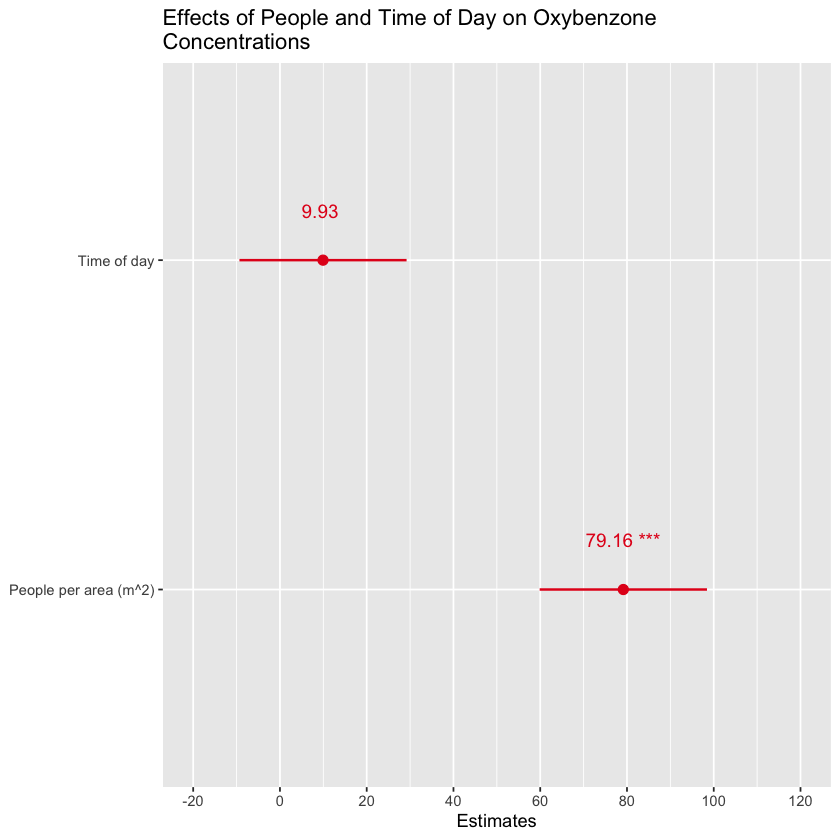

In [325]:
sjPlot::plot_model(BP3.vs.time.ppl, 
                   axis.labels=c("People per area (m^2)", "Time of day"),
                   show.values=TRUE, show.p=TRUE,
                   title="Effects of People and Time of Day on Oxybenzone Concentrations")

In [326]:
BP3effects_ppl <- effects::effect(term= "ppl_msq_s", mod= BP3.vs.time.ppl)
#summary(BP3effects_ppl)

Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
“the predictors Time_s, ppl_msq_s are one-column matrices that were converted to vectors”


In [327]:
BP3_ppl <- as.data.frame(BP3effects_ppl)

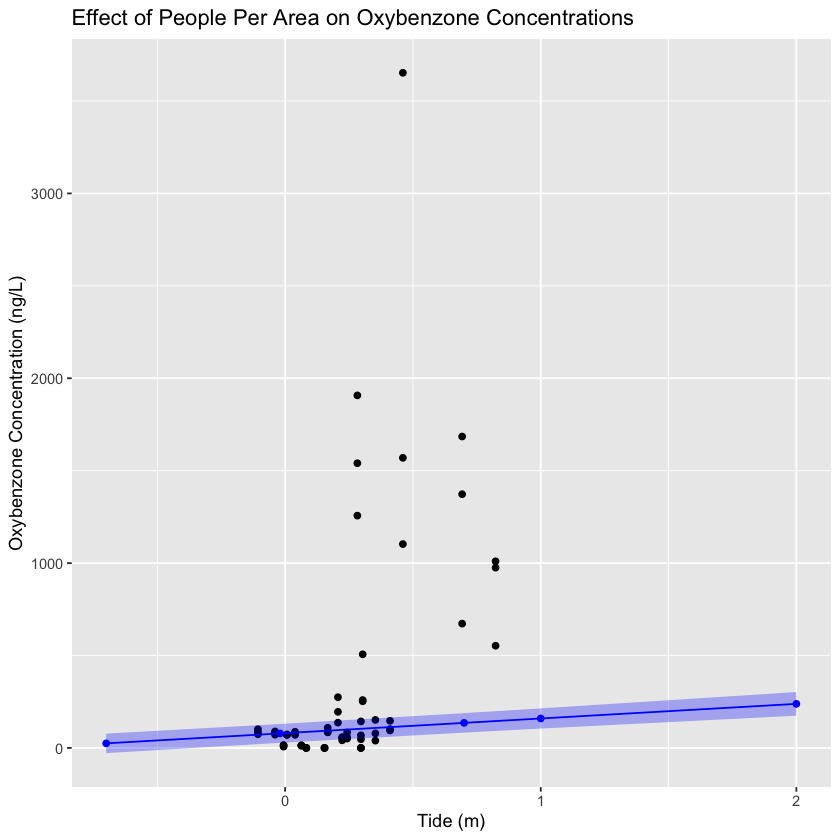

In [328]:
BP3ppl_plot <- ggplot() + 
  #2
geom_point(data=subset(Diamond_all_fin), aes(Tide, OC)) + 
  #3
  geom_point(data= BP3_ppl, aes(x=ppl_msq_s, y=fit), color="blue") +
  #4
  geom_line(data= BP3_ppl, aes(x=ppl_msq_s, y=fit), color="blue") +
  #5
  geom_ribbon(data= BP3_ppl, aes(x=ppl_msq_s, ymin=lower, ymax=upper), alpha= 0.3, fill="blue") +
  #6
  labs(x="Tide (m)", y="Oxybenzone Concentration (ng/L)") +
  ggtitle("Effect of People Per Area on Oxybenzone Concentrations")

BP3ppl_plot

In [329]:
# LMM2
# Concentration of OC by time of day and ppl_msq
#OC.vs.time.ppl <- lmer(OC ~ Time_s + ppl_msq_s + (1|Moon_s), data = Diamond_all_fin)

In [330]:
sjPlot::tab_model(OC.vs.time.ppl, 
                  show.re.var= TRUE, 
                  pred.labels =c("(Intercept)", "Time of day", "People per area (m^2)"), 
                  dv.labels= "Effects of People and Time of Day on Octocrylene Concentrations")

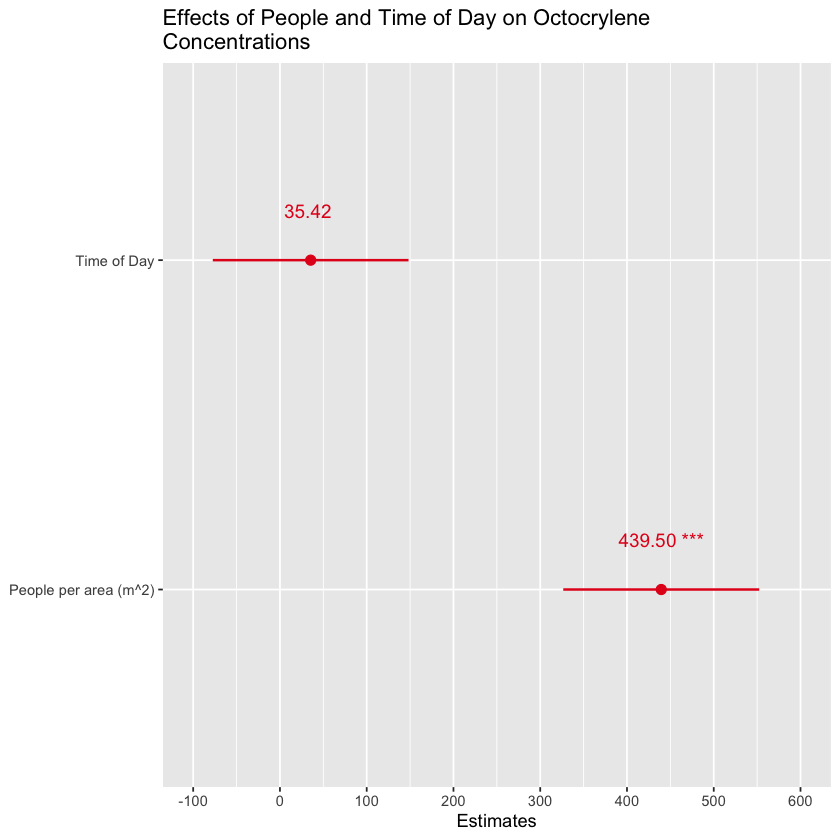

In [331]:
sjPlot::plot_model(OC.vs.time.ppl, 
                   axis.labels=c("People per area (m^2)", "Time of Day"),
                   show.values=TRUE, show.p=TRUE,
                   title="Effects of People and Time of Day on Octocrylene Concentrations")

In [332]:
OCeffects_ppl <- effects::effect(term= "ppl_msq_s", mod= OC.vs.time.ppl)
#summary(BP3effects_ppl)

Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
“the predictors Time_s, ppl_msq_s are one-column matrices that were converted to vectors”


In [333]:
OC_ppl <- as.data.frame(OCeffects_ppl)

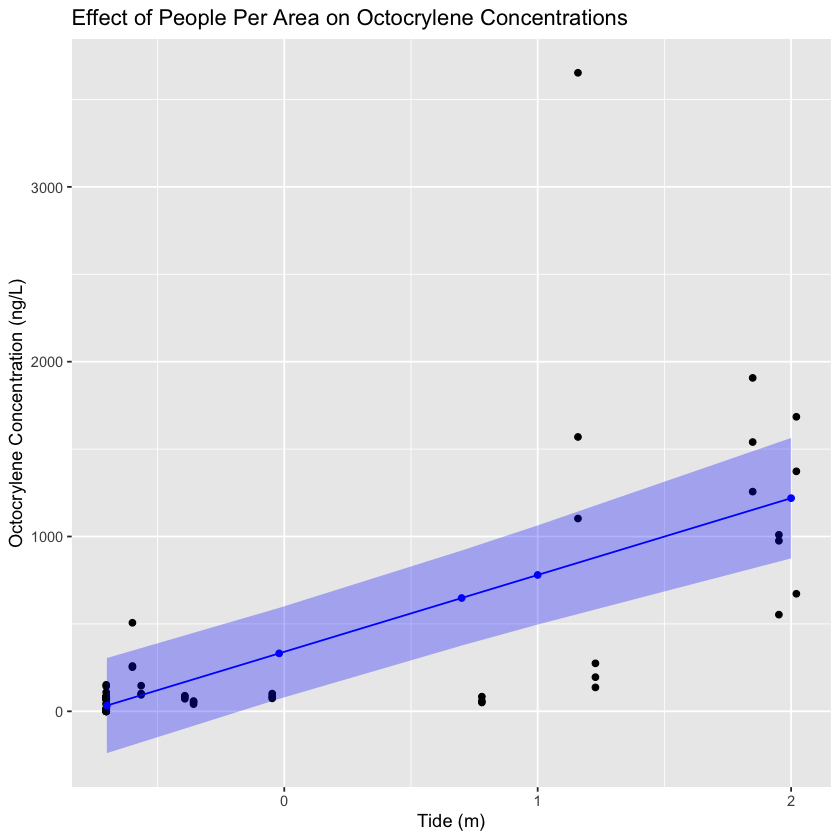

In [334]:
OCppl_plot <- ggplot() + 
  #2
geom_point(data=subset(Diamond_all_fin), aes(ppl_msq_s, OC)) + 
  #3
  geom_point(data= OC_ppl, aes(x=ppl_msq_s, y=fit), color="blue") +
  #4
  geom_line(data= OC_ppl, aes(x=ppl_msq_s, y=fit), color="blue") +
  #5
  geom_ribbon(data= OC_ppl, aes(x=ppl_msq_s, ymin=lower, ymax=upper), alpha= 0.3, fill="blue") +
  #6
  labs(x="Tide (m)", y="Octocrylene Concentration (ng/L)") +
  ggtitle("Effect of People Per Area on Octocrylene Concentrations")

OCppl_plot

In [335]:
# LMM11
# Effect of tide, pretide and posttide [BP3], time completely excluded. 
#BP3_tide_pre_post <- lmer(BP3 ~ Tide + PreTide + PostTide + (1|Moon_s), data = Diamond_all_fin)


In [336]:
sjPlot::tab_model(BP3_tide_pre_post, 
                  show.re.var= TRUE, 
                  pred.labels =c("(Intercept)","Tide", "Pre Tide", "Post Tide"), 
                  dv.labels= "Effects of Tide, PreTide and PostTide on Oxybenzone Concentrations")

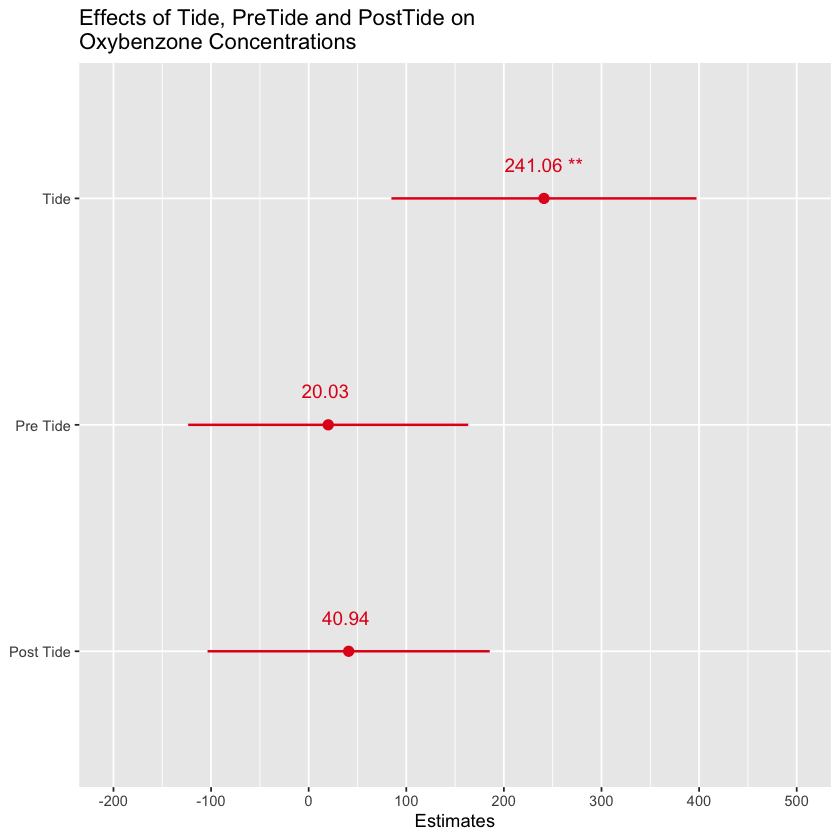

In [337]:
sjPlot::plot_model(BP3_tide_pre_post, 
                   axis.labels=c("Post Tide", "Pre Tide", "Tide"),
                   show.values=TRUE, show.p=TRUE,
                   title="Effects of Tide, PreTide and PostTide on Oxybenzone Concentrations")

In [338]:
BP3effects_tide <- effects::effect(term= "Tide", mod= BP3_tide_pre_post)
#summary(BP3effects_tide)

In [339]:
BP3_tide <- as.data.frame(BP3effects_tide)

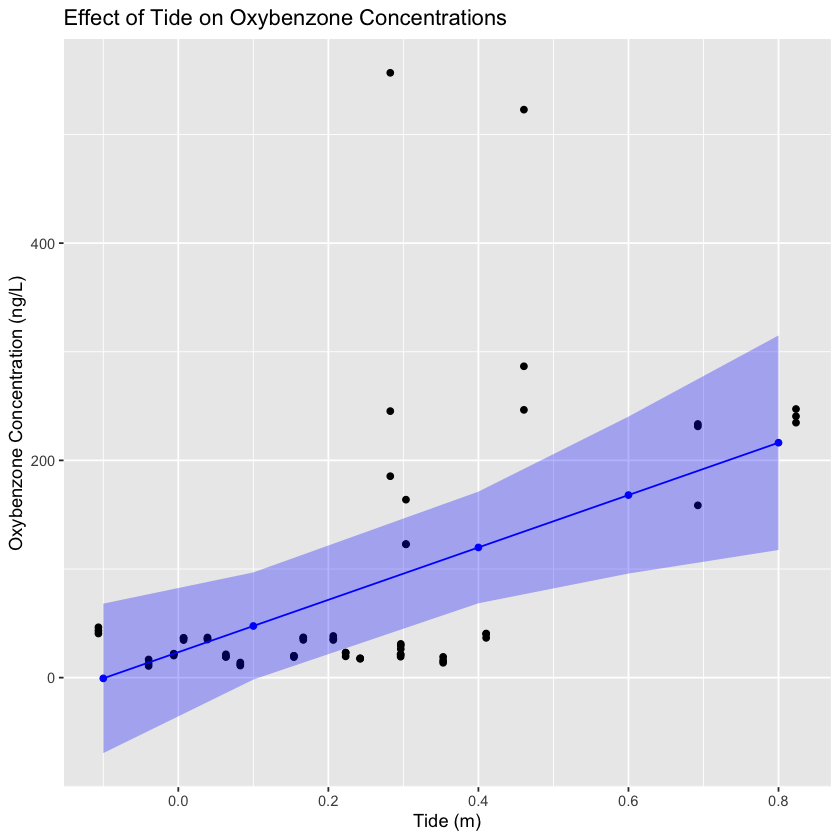

In [340]:
BP3tide_plot <- ggplot() + 
  #2
geom_point(data=subset(Diamond_all_fin), aes(Tide, BP3)) + 
  #3
  geom_point(data= BP3_tide, aes(x=Tide, y=fit), color="blue") +
  #4
  geom_line(data= BP3_tide, aes(x=Tide, y=fit), color="blue") +
  #5
  geom_ribbon(data= BP3_tide, aes(x=Tide, ymin=lower, ymax=upper), alpha= 0.3, fill="blue") +
  #6
  labs(x="Tide (m)", y="Oxybenzone Concentration (ng/L)") +
  ggtitle("Effect of Tide on Oxybenzone Concentrations")

BP3tide_plot

In [341]:
# LMM12
# Effect of tide, pretide and posttide [OC], time completely excluded. 
#OC_tide_pre_post <- lmer(OC ~ Tide + PreTide + PostTide + (1|Moon_s), data = Diamond_all_fin)

In [342]:
sjPlot::tab_model(OC_tide_pre_post, 
                  show.re.var= TRUE, 
                  pred.labels =c("(Intercept)","Tide", "Pre Tide", "Post Tide"), 
                  dv.labels= "Effects of Tide, PreTide and PostTide on Octocrylene Concentrations")

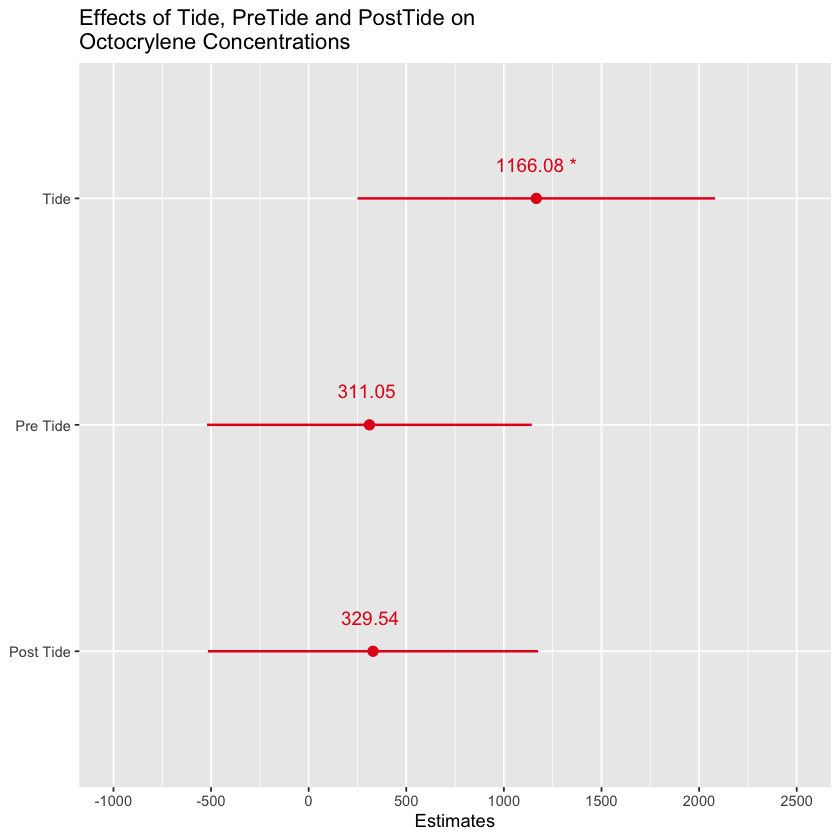

In [343]:
sjPlot::plot_model(OC_tide_pre_post, 
                   axis.labels=c("Post Tide", "Pre Tide", "Tide"),
                   show.values=TRUE, show.p=TRUE,
                   title="Effects of Tide, PreTide and PostTide on Octocrylene Concentrations")

In [344]:
OCeffects_tide <- effects::effect(term= "Tide", mod= OC_tide_pre_post)
#summary(OCeffects_tide)

In [345]:
OC_tide <- as.data.frame(OCeffects_tide)

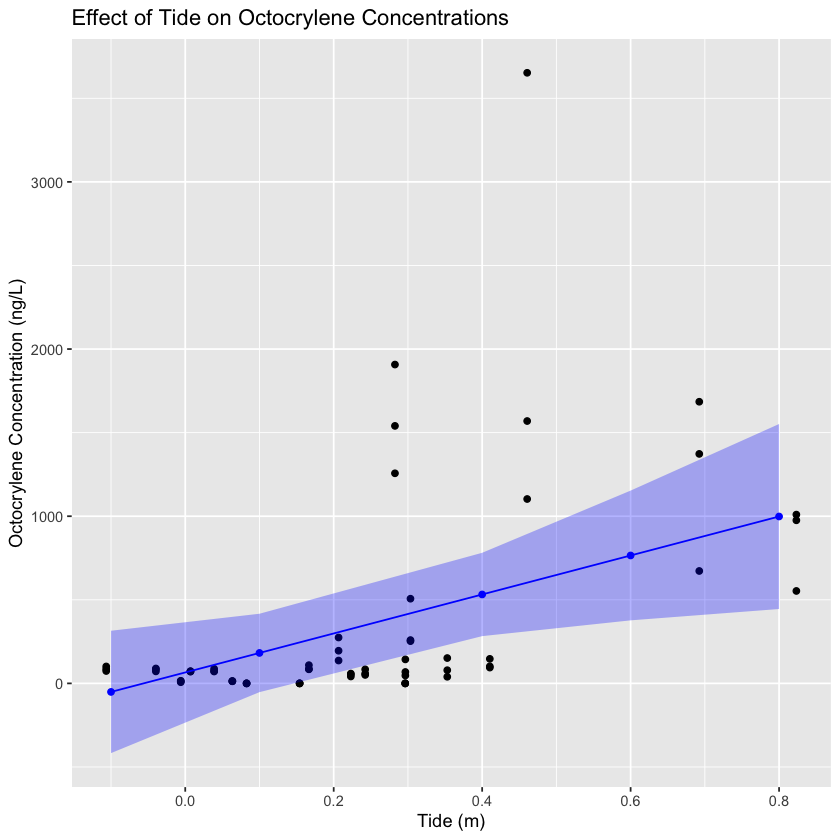

In [346]:
OCtide_plot <- ggplot() + 
  #2
geom_point(data=subset(Diamond_all_fin), aes(Tide, OC)) + 
  #3
  geom_point(data= OC_tide, aes(x=Tide, y=fit), color="blue") +
  #4
  geom_line(data= OC_tide, aes(x=Tide, y=fit), color="blue") +
  #5
  geom_ribbon(data= OC_tide, aes(x=Tide, ymin=lower, ymax=upper), alpha= 0.3, fill="blue") +
  #6
  labs(x="Tide (m)", y="Octocrylene Concentration (ng/L)") +
  ggtitle("Effect of Tide on Octocrylene Concentrations")

OCtide_plot